In [1]:
# 用于数据处理和数值计算的核心库
import pandas as pd
import numpy as np

# 用于在组件间管理事件的队列
import queue

# 用于绘制结果
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 其他标准库
import time
from datetime import datetime

from dashscope import api_key

In [2]:
def generate_sample_data(filename, num_days=500):
    """生成具有均值回归价差的样本期货数据。"""
    dates = pd.to_datetime(pd.date_range(end=datetime.now(), periods=num_days, freq='B'))
    
    # 基础价格走势（随机游走）
    base_price = 100 + np.random.randn(num_days).cumsum() * 0.5
    
    # 使用正弦波+噪声创建一个均值回归的价差
    mean_spread = 2.0
    spread_amplitude = 1.5
    spread_noise = np.random.randn(num_days) * 0.2
    spread = mean_spread + spread_amplitude * np.sin(np.linspace(0, 10 * np.pi, num_days)) + spread_noise
    
    # 创建近月和远月价格
    # 我们定义价差 = 远月价格 - 近月价格
    price_near = base_price - spread / 2
    price_far = base_price + spread / 2
    
    df = pd.DataFrame({
        'Date': dates,
        'NEAR': np.round(price_near, 2),
        'FAR': np.round(price_far, 2)
    })
    
    df.set_index('Date', inplace=True)
    df.to_csv(filename)
    print(f"已生成样本数据: {filename}")

# 为美国和中国市场的例子生成数据
generate_sample_data('cl_data.csv', num_days=750)
generate_sample_data('m_data.csv', num_days=750)

已生成样本数据: cl_data.csv
已生成样本数据: m_data.csv


In [3]:
class Event:
    """所有事件类型的基类。"""
    pass

class MarketEvent(Event):
    """处理接收到新市场数据的事件。"""
    def __init__(self):
        self.type = 'MARKET'

class SignalEvent(Event):
    """处理从策略对象发送信号的事件。"""
    def __init__(self, symbol, datetime, signal_type, strength=1.0):
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type # 'LONG_SPREAD' (做多价差) 或 'SHORT_SPREAD' (做空价差)
        self.strength = strength

class OrderEvent(Event):
    """处理向执行系统发送订单的事件。"""
    def __init__(self, symbol, order_type, quantity, direction):
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type # 'MKT' (市价单) 或 'LMT' (限价单)
        self.quantity = quantity
        self.direction = direction # 'BUY' (买入) 或 'SELL' (卖出)

class FillEvent(Event):
    """封装订单的成交，即一笔交易的执行。"""
    def __init__(self, timeindex, symbol, exchange, quantity, direction, fill_cost, commission=0.0):
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost
        self.commission = commission

In [4]:
class CSVDataHandler:
    """从CSV文件读取数据并逐条提供。"""
    def __init__(self, events_queue, csv_path, symbols):
        self.events = events_queue
        self.csv_path = csv_path
        self.symbols = symbols
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        
        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        self.symbol_data = pd.read_csv(
            self.csv_path, header=0, index_col=0, parse_dates=True
        ).to_records(index=True)
        self.data_iterator = self.symbol_data.__iter__()

    def get_latest_bar(self, symbol):
        """返回某个交易品种的最新K线数据。"""
        try:
            return self.latest_symbol_data[symbol]
        except KeyError:
            print("该交易品种在历史数据集中不可用。")
            return None

    def update_bars(self):
        """将数据源的下一条K线推送到latest_symbol_data中。"""
        try:
            bar = next(self.data_iterator)
        except StopIteration:
            self.continue_backtest = False
            return
        
        # 我们为价差对使用一个单一的'symbol'
        self.latest_symbol_data[self.symbols[0]] = bar
        self.events.put(MarketEvent())

In [5]:
class CalendarSpreadZScoreStrategy:
    """
    一个基于Z-分数交易日历价差的简单策略。
    """
    def __init__(self, data_handler, events_queue, symbol, lookback_window=60, z_threshold=2.0):
        self.data_handler = data_handler
        self.events = events_queue
        self.symbol = symbol
        self.lookback_window = lookback_window
        self.z_threshold = z_threshold
        
        self.spread_history = pd.Series(dtype=float)
        self.bought = False # 一个简单的标志，用来追踪我们是否在场内
        self.sold = False

    def calculate_signals(self, event):
        """在接收到MarketEvent时计算信号。"""
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.symbol)
            if bar is not None:
                # 计算价差: 远月价格 - 近月价格
                spread = bar['FAR'] - bar['NEAR']
                self.spread_history[bar['Date']] = spread

                if len(self.spread_history) > self.lookback_window:
                    # 计算滚动均值、标准差和Z-分数
                    rolling_mean = self.spread_history.rolling(window=self.lookback_window).mean().iloc[-1]
                    rolling_std = self.spread_history.rolling(window=self.lookback_window).std().iloc[-1]
                    
                    if rolling_std > 0: # 避免除以零
                        z_score = (spread - rolling_mean) / rolling_std

                        # --- 交易逻辑 ---
                        # 如果我们不在场内
                        if not self.bought and not self.sold:
                            if z_score > self.z_threshold:
                                # 价差异常高 -> 卖出价差 (卖出远月, 买入近月)
                                signal = SignalEvent(self.symbol, bar['Date'], 'SHORT_SPREAD')
                                self.events.put(signal)
                                self.sold = True
                            elif z_score < -self.z_threshold:
                                # 价差异常低 -> 买入价差 (买入远月, 卖出近月)
                                signal = SignalEvent(self.symbol, bar['Date'], 'LONG_SPREAD')
                                self.events.put(signal)
                                self.bought = True
                        
                        # 如果我们在场内，检查是否退出
                        elif self.sold and z_score < 0.5:
                            # 价差向均值回归 -> 退出空头头寸
                            signal = SignalEvent(self.symbol, bar['Date'], 'EXIT_SHORT')
                            self.events.put(signal)
                            self.sold = False
                        elif self.bought and z_score > -0.5:
                            # 价差向均值回归 -> 退出多头头寸
                            signal = SignalEvent(self.symbol, bar['Date'], 'EXIT_LONG')
                            self.events.put(signal)
                            self.bought = False

In [38]:
class BasicPortfolio:
    """
    管理头寸、现金和业绩。
    基于信号生成订单。（已修正）
    """
    def __init__(self, data_handler, events_queue, start_date, symbol, initial_capital=100000.0):
        self.data_handler = data_handler
        self.events = events_queue
        self.start_date = start_date
        self.symbol = symbol  # 存储策略的通用名称
        self.initial_capital = initial_capital
        
        self.current_positions = {'NEAR': 0, 'FAR': 0}
        self.all_holdings = []
        # 初始化时，确保 all_holdings 包含初始状态
        self.current_holdings = self._construct_current_holdings()
        self.all_holdings.append(self.current_holdings.copy())

    def _construct_current_holdings(self):
        """构建当前持仓的字典。"""
        d = {'datetime': pd.to_datetime(self.start_date), 'cash': self.initial_capital, 'commission': 0.0, 'total': self.initial_capital}
        return d
    
    def update_timeindex(self, event):
        """
        在新的市场K线到达时，更新投资组合的持仓价值。
        这是我们的盯市计算。
        """
        if event.type == 'MARKET':
            # 使用 self.symbol 来调用 get_latest_bar，这更具通用性
            bar = self.data_handler.get_latest_bar(self.symbol)
            if bar is not None:
                # Stooq返回的bar是record array，字段名为'Date'
                dt = bar['Date']
                
                self.current_holdings['datetime'] = dt
                
                total_value = self.current_holdings['cash']
                total_value += self.current_positions['NEAR'] * bar['NEAR']
                total_value += self.current_positions['FAR'] * bar['FAR']
                self.current_holdings['total'] = total_value
                
                self.all_holdings.append(self.current_holdings.copy())

    def update_positions_from_fill(self, fill):
        """接收一个FillEvent并更新头寸字典。"""
        fill_dir = 1 if fill.direction == 'BUY' else -1
        self.current_positions[fill.symbol] += fill_dir * fill.quantity

    def update_holdings_from_fill(self, fill):
        """接收一个FillEvent并更新持仓字典。"""
        fill_dir = 1 if fill.direction == 'BUY' else -1
        cost = fill.fill_cost * fill_dir
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['commission'] += fill.commission

    def generate_naive_order(self, signal):
        """简单地将一个Signal对象转换为价差两条腿的OrderEvent。"""
        if signal.type == 'SIGNAL':
            quantity = 10
            
            if signal.signal_type == 'LONG_SPREAD':
                order_far = OrderEvent('FAR', 'MKT', quantity, 'BUY')
                order_near = OrderEvent('NEAR', 'MKT', quantity, 'SELL')
            elif signal.signal_type == 'SHORT_SPREAD':
                order_far = OrderEvent('FAR', 'MKT', quantity, 'SELL')
                order_near = OrderEvent('NEAR', 'MKT', quantity, 'BUY')
            elif signal.signal_type == 'EXIT_LONG':
                order_far = OrderEvent('FAR', 'MKT', self.current_positions.get('FAR', 0), 'SELL')
                order_near = OrderEvent('NEAR', 'MKT', abs(self.current_positions.get('NEAR', 0)), 'BUY')
            elif signal.signal_type == 'EXIT_SHORT':
                order_far = OrderEvent('FAR', 'MKT', abs(self.current_positions.get('FAR', 0)), 'BUY')
                order_near = OrderEvent('NEAR', 'MKT', self.current_positions.get('NEAR', 0), 'SELL')
            
            self.events.put(order_far)
            self.events.put(order_near)

    def create_equity_curve_dataframe(self):
        """从all_holdings列表创建一个pandas DataFrame。"""
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0 + curve['returns']).cumprod()
        return curve

In [7]:
class SimulatedExecutionHandler:
    """
    模拟订单的执行，包括滑点和佣金。
    """
    def __init__(self, events_queue, data_handler, commission_per_trade=5.0, slippage_per_trade=0.01):
        self.events = events_queue
        self.data_handler = data_handler
        self.commission = commission_per_trade
        self.slippage = slippage_per_trade

    def execute_order(self, event):
        """
        接收一个OrderEvent并将其转换为一个FillEvent。
        """
        if event.type == 'ORDER':
            # 获取正在交易的合约腿的当前市价
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            price = bar[event.symbol]
            
            # 应用滑点
            if event.direction == 'BUY':
                fill_price = price + self.slippage
            else: # SELL
                fill_price = price - self.slippage
            
            fill_cost = fill_price * event.quantity
            
            fill_event = FillEvent(
                bar['Date'], event.symbol, 'SIMULATED', 
                event.quantity, event.direction, fill_cost, self.commission
            )
            self.events.put(fill_event)

In [39]:
class Backtest:
    """
    主回测协调器。（已修正）
    """
    def __init__(
        self, csv_path, symbol, initial_capital, lookback, z_score,
        start_date, data_handler_cls, strategy_cls, portfolio_cls, execution_handler_cls
    ):
        self.events = queue.Queue()
        self.csv_path = csv_path
        self.symbol_list = [symbol]  # 仍然需要这个用于通用性
        self.initial_capital = initial_capital
        self.start_date = start_date
        
        self.data_handler = data_handler_cls(self.events, self.csv_path, self.symbol_list)
        self.strategy = strategy_cls(self.data_handler, self.events, symbol, lookback, z_score)
        # 关键改动：将 symbol 传递给 Portfolio
        self.portfolio = portfolio_cls(self.data_handler, self.events, self.start_date, symbol, self.initial_capital)
        self.execution_handler = execution_handler_cls(self.events, self.data_handler)
        
    def _run_backtest(self):
        """主事件循环。"""
        print("正在运行回测...")
        while True:
            if not self.data_handler.continue_backtest:
                break
            
            self.data_handler.update_bars()
            
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.portfolio.update_timeindex(event)
                            self.strategy.calculate_signals(event)
                        elif event.type == 'SIGNAL':
                            self.portfolio.generate_naive_order(event)
                        elif event.type == 'ORDER':
                            self.execution_handler.execute_order(event)
                        elif event.type == 'FILL':
                            self.portfolio.update_positions_from_fill(event)
                            self.portfolio.update_holdings_from_fill(event)
        print("回测结束。")

    def simulate_trading(self):
        """模拟交易并返回业绩统计数据。"""
        self._run_backtest()
        # 增加一个检查，以防 all_holdings 仍然为空
        if len(self.portfolio.all_holdings) > 1:
            return self.portfolio.create_equity_curve_dataframe()
        else:
            print("未能记录足够的交易数据来生成业绩报告。")
            return None

def plot_performance(performance, strategy, title):
    """绘制回测的业绩图。"""
    
    # 1. 权益曲线
    fig = plt.figure(figsize=(12, 16))
    fig.suptitle(title, fontsize=16)
    
    ax1 = fig.add_subplot(311)
    ax1.plot(performance['equity_curve'], label='权益曲线')
    ax1.set_title('投资组合权益曲线')
    ax1.set_ylabel('累计回报')
    ax1.grid(True)
    ax1.legend()
    
    # 2. 价差与滚动均值
    ax2 = fig.add_subplot(312)
    spread = strategy.spread_history
    mean = spread.rolling(window=strategy.lookback_window).mean()
    ax2.plot(spread.index, spread.values, label='价差 (远月 - 近月)')
    ax2.plot(mean.index, mean.values, label=f'{strategy.lookback_window}日滚动均值', linestyle='--')
    ax2.set_title('价差与滚动均值')
    ax2.set_ylabel('价格差')
    ax2.grid(True)
    ax2.legend()
    
    # 3. Z-分数与交易信号
    ax3 = fig.add_subplot(313)
    z_score = (spread - mean) / spread.rolling(window=strategy.lookback_window).std()
    ax3.plot(z_score.index, z_score.values, label='Z-分数')
    ax3.axhline(strategy.z_threshold, color='r', linestyle='--', label=f'阈值 ({strategy.z_threshold})')
    ax3.axhline(-strategy.z_threshold, color='r', linestyle='--')
    ax3.axhline(0.0, color='k', linestyle='-')
    
    # 绘制交易入场/出场点
    trade_points = performance[performance['commission'] > 0]
    buy_signals = trade_points[trade_points['returns'].notna()] # 找到入场点的粗略方法
    
    ax3.plot(z_score.loc[buy_signals.index].index, z_score.loc[buy_signals.index], '^', color='g', markersize=10, label='入场点')
    # 注意：更稳健的交易点绘制需要存储交易对象。
    
    ax3.set_title('价差Z-分数与交易信号')
    ax3.set_ylabel('Z-分数')
    ax3.set_xlabel('日期')
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def calculate_performance_metrics(performance):
    """计算并打印关键业绩指标。"""
    total_return = performance['equity_curve'].iloc[-1] - 1
    sharpe_ratio = performance['returns'].mean() / performance['returns'].std() * np.sqrt(252) # 年化
    
    # 最大回撤
    cum_returns = performance['equity_curve']
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    print(f"总回报率: {total_return:.2%}")
    print(f"夏普比率: {sharpe_ratio:.2f}")
    print(f"最大回撤: {max_drawdown:.2%}")

正在运行回测...
回测结束。

--- 美国市场 (WTI原油) 业绩 ---
总回报率: -0.33%
夏普比率: -2.48
最大回撤: nan%


C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 25253 (\N{CJK UNIFIED IDEOGRAPH-62A5}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

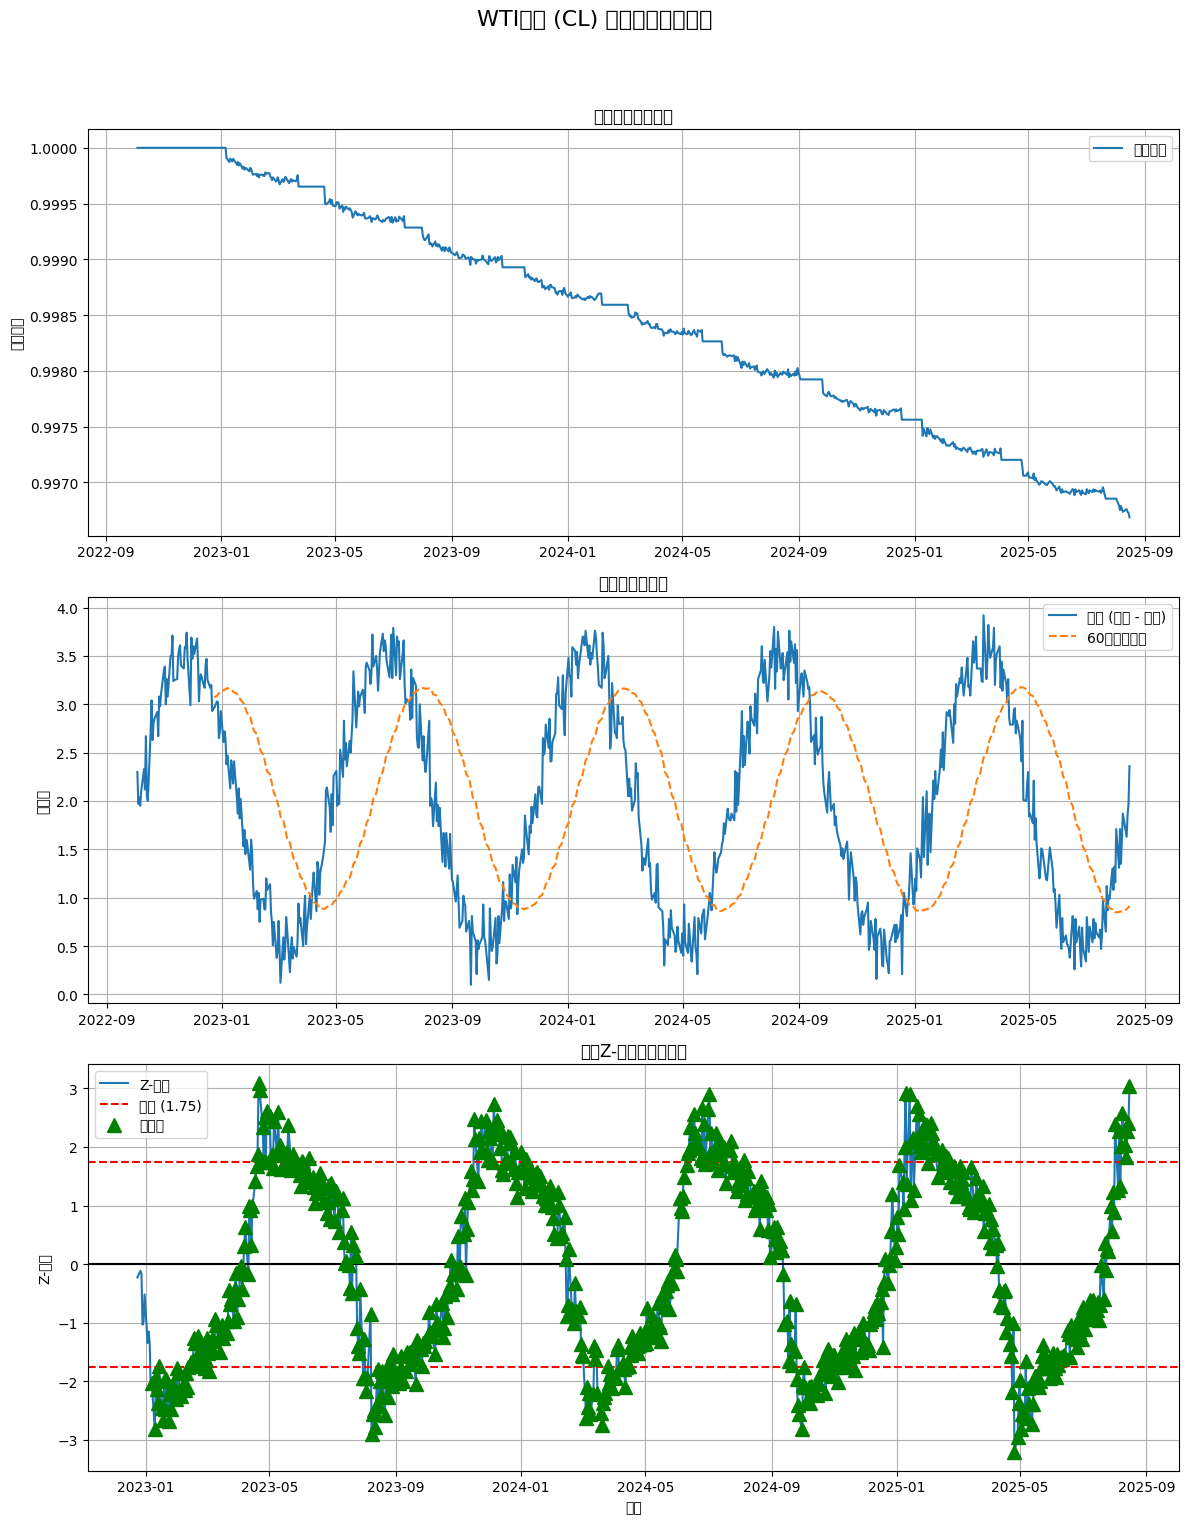

In [9]:
# --- 美国市场配置 ---
us_csv_path = 'cl_data.csv'
us_symbol = 'CL_SPREAD'
us_initial_capital = 100000.0
us_start_date = pd.to_datetime('2023-01-01') # 开始日期仅用于投资组合初始化
us_lookback = 60 # 天
us_z_score = 1.75 # Z-分数入场阈值

# --- 运行回测 ---
us_backtest = Backtest(
    csv_path=us_csv_path,
    symbol=us_symbol,
    initial_capital=us_initial_capital,
    start_date=us_start_date,
    lookback=us_lookback,
    z_score=us_z_score,
    data_handler_cls=CSVDataHandler,
    strategy_cls=CalendarSpreadZScoreStrategy,
    portfolio_cls=BasicPortfolio,
    execution_handler_cls=SimulatedExecutionHandler
)

us_performance = us_backtest.simulate_trading()

# --- 分析结果 ---
print("\n--- 美国市场 (WTI原油) 业绩 ---")
calculate_performance_metrics(us_performance)
plot_performance(us_performance, us_backtest.strategy, "WTI原油 (CL) 日历价差策略表现")

正在运行回测...
回测结束。

--- 中国市场 (豆粕) 业绩 ---
总回报率: -0.42%
夏普比率: -3.02
最大回撤: nan%


C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 25253 (\N{CJK UNIFIED IDEOGRAPH-62A5}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3184659264.py:100: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

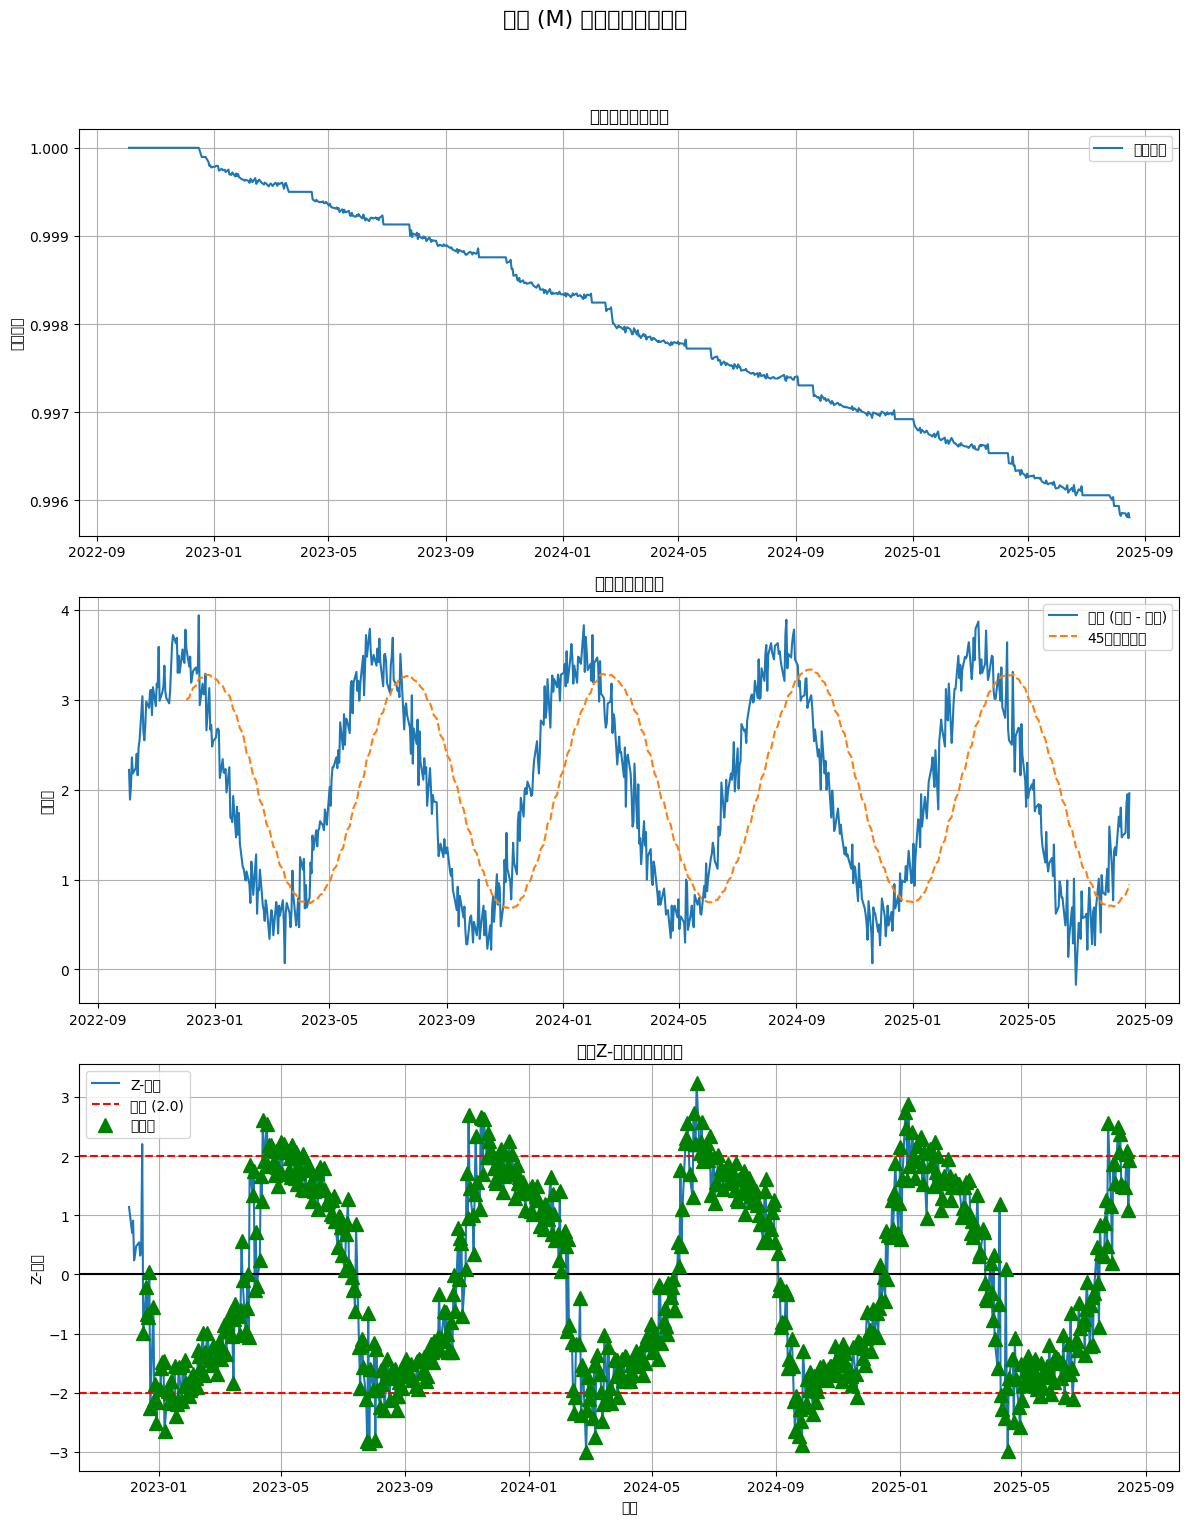

In [10]:
# --- 中国市场配置 ---
cn_csv_path = 'm_data.csv'
cn_symbol = 'M_SPREAD'
cn_initial_capital = 100000.0
cn_start_date = pd.to_datetime('2023-01-01')
cn_lookback = 45 # 使用一个稍有不同的回看窗口
cn_z_score = 2.0 # 使用一个不同的Z-分数阈值

# --- 运行回测 ---
cn_backtest = Backtest(
    csv_path=cn_csv_path,
    symbol=cn_symbol,
    initial_capital=cn_initial_capital,
    start_date=cn_start_date,
    lookback=cn_lookback,
    z_score=cn_z_score,
    data_handler_cls=CSVDataHandler,
    strategy_cls=CalendarSpreadZScoreStrategy,
    portfolio_cls=BasicPortfolio,
    execution_handler_cls=SimulatedExecutionHandler
)

cn_performance = cn_backtest.simulate_trading()

# --- 分析结果 ---
print("\n--- 中国市场 (豆粕) 业绩 ---")
calculate_performance_metrics(cn_performance)
plot_performance(cn_performance, cn_backtest.strategy, "豆粕 (M) 日历价差策略表现")

In [11]:
# 导入Nasdaq Data Link库
import nasdaqdatalink as nasdaq

class NasdaqDataHandler:
    """
    从Nasdaq Data Link获取数据，并以K线形式提供。
    """
    def __init__(self, events_queue, symbol_pair, start_date, end_date, api_key):
        self.events = events_queue
        self.symbol_pair = symbol_pair # 例如: ['CME/CL1', 'CME/CL2']
        self.start_date = start_date
        self.end_date = end_date
        self.api_key = api_key
        
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        
        # 配置API密钥
        nasdaq.api_config.api_key = self.api_key
        
        self._fetch_and_prepare_data()

    def _fetch_and_prepare_data(self):
        """获取、合并并准备数据。"""
        print(f"正在从Nasdaq Data Link获取数据: {self.symbol_pair[0]} 和 {self.symbol_pair[1]}...")
        
        # 获取近月合约数据
        near_data = nasdaq.get(self.symbol_pair[0], start_date=self.start_date, end_date=self.end_date)
        
        # 获取次近月合约数据
        far_data = nasdaq.get(self.symbol_pair[1], start_date=self.start_date, end_date=self.end_date)
        
        print("数据获取完毕。正在处理...")
        
        # 将数据合并到一个DataFrame中
        # 我们只关心结算价 'Settle'
        df = pd.DataFrame(index=near_data.index)
        df['NEAR'] = near_data['Settle']
        df['FAR'] = far_data['Settle']
        
        # 删除任何包含NaN的行（例如，节假日导致的数据不对齐）
        df.dropna(inplace=True)
        
        # 将准备好的数据转换为回测器可用的格式
        self.symbol_data = df.to_records(index=True)
        self.data_iterator = self.symbol_data.__iter__()

    def get_latest_bar(self, symbol):
        """返回最新的K线数据。"""
        # 注意: 这里的symbol参数是通用的，因为我们处理的是一个价差对
        try:
            return self.latest_symbol_data[self.symbol_pair[0]]
        except KeyError:
            return None

    def update_bars(self):
        """将数据源的下一条K线推送到latest_symbol_data中。"""
        try:
            bar = next(self.data_iterator)
        except StopIteration:
            self.continue_backtest = False
            return
        
        self.latest_symbol_data[self.symbol_pair[0]] = bar
        self.events.put(MarketEvent())

In [54]:
import pandas as pd
from urllib.error import HTTPError

class StooqDataHandler:
    """
    从 Stooq.com 获取数据，并以K线形式提供。
    无需API密钥。
    """
    def __init__(self, events_queue, symbol_pair, start_date, end_date):
        self.events = events_queue
        self.symbol_pair = symbol_pair # 例如: ['cl.f.1', 'cl.f.2']
        self.start_date = start_date.replace('-', '') # Stooq URL需要YYYYMMDD格式
        self.end_date = end_date.replace('-', '')
        
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        
        self._fetch_and_prepare_data()

    def _build_stooq_url(self, ticker):
        """构建用于下载Stooq数据的URL。"""
        return f"https://stooq.com/q/d/l/?s={ticker}&d1={self.start_date}&d2={self.end_date}&i=d"

    def _fetch_and_prepare_data(self):
        """获取、合并并准备数据。"""
        print(f"正在从 Stooq.com 获取数据: {self.symbol_pair[0]} 和 {self.symbol_pair[1]}...")
        
        try:
            # 构建URL并获取数据
            near_url = self._build_stooq_url(self.symbol_pair[0])
            far_url = self._build_stooq_url(self.symbol_pair[1])
            
            # 指定列名以匹配Stooq的CSV格式（无表头）
            column_names = ['Ticker', 'Freq', 'Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
            
            near_data = pd.read_csv(near_url, header=None, names=column_names)
            far_data = pd.read_csv(far_url, header=None, names=column_names)
            print(f"Near data raw rows: {len(near_data)}")
            if len(near_data) > 0:
                print("Near raw head:")
                print(near_data.head())
            
            print("数据获取成功。正在处理...")
            
            # Stooq返回的数据是按日期降序排列的，我们需要将其反转
            near_data = near_data.iloc[::-1].reset_index(drop=True)
            far_data = far_data.iloc[::-1].reset_index(drop=True)
            
            # 将 'Date' 列转换为 datetime 对象
            near_data['Date'] = pd.to_datetime(near_data['Date'])
            far_data['Date'] = pd.to_datetime(far_data['Date'])
            
            # 将数据合并到一个DataFrame中
            df = pd.merge(near_data[['Date', 'Close']], far_data[['Date', 'Close']], on='Date', suffixes=('_near', '_far'))
            
            # 重命名列以匹配我们引擎的要求
            df.rename(columns={'Close_near': 'NEAR', 'Close_far': 'FAR'}, inplace=True)
            
            # 添加调试打印
            print(f"合并后的数据行数: {len(df)}")
            if len(df) > 0:
                print("前5行数据:")
                print(df.head())
                print("后5行数据:")
                print(df.tail())
            else:
                print("警告: 合并数据为空，可能ticker无效或无重叠日期。")
            
            if df.empty:
                print("错误：在指定日期范围内未找到重叠的数据。请检查合约代码或日期范围。")
                self.continue_backtest = False
                return
            # 将准备好的数据转换为回测器可用的格式
            self.symbol_data = df.to_records(index=False)
            self.data_iterator = self.symbol_data.__iter__()
        except HTTPError as e:
            print(f"数据获取失败！❌ HTTP错误: {e}")
            print("请检查合约代码是否正确，或Stooq网站是否可用。")
            self.continue_backtest = False
        except Exception as e:
            print(f"发生未知错误: {e}")
            self.continue_backtest = False

    def get_latest_bar(self, symbol):
        """返回最新的K线数据。"""
        try:
            return self.latest_symbol_data[self.symbol_pair[0]]
        except KeyError:
            return None

    def update_bars(self):
        """将数据源的下一条K线推送到latest_symbol_data中。"""
        if not self.continue_backtest:
            return
        try:
            bar = next(self.data_iterator)
            self.latest_symbol_data[self.symbol_pair[0]] = bar
            self.events.put(MarketEvent())
        except StopIteration:
            self.continue_backtest = False

In [56]:
# --- 使用 Stooq 真实数据的配置 ---
# Stooq 数据源
stooq_symbols = ['cl.f', 'cl.f'] # WTI原油的连续近月和次近月合约代码
stooq_symbol_name = 'CL_STOOQ_SPREAD'
stooq_start_date = '2024-12-01'
stooq_end_date = '2024-12-31'

initial_capital = 100000.0
lookback = 60 # 天
z_score = 2.0 # 阈值

# --- 运行使用 Stooq 数据的回测 ---
stooq_backtest = Backtest(
    csv_path=None,  # 我们不再需要CSV路径
    symbol=stooq_symbol_name,
    initial_capital=initial_capital,
    start_date=stooq_start_date,
    lookback=lookback,
    z_score=z_score,
    # 关键改动：使用新的 StooqDataHandler
    data_handler_cls=lambda events, path, symbols: StooqDataHandler(
        events, 
        stooq_symbols,  # 传入Stooq的合约代码
        stooq_start_date, 
        stooq_end_date
    ),
    strategy_cls=CalendarSpreadZScoreStrategy,
    portfolio_cls=BasicPortfolio,
    execution_handler_cls=SimulatedExecutionHandler
)



正在从 Stooq.com 获取数据: cl.f 和 cl.f...
Near data raw rows: 0
数据获取成功。正在处理...
合并后的数据行数: 0
警告: 合并数据为空，可能ticker无效或无重叠日期。
错误：在指定日期范围内未找到重叠的数据。请检查合约代码或日期范围。


In [46]:
stooq_performance = stooq_backtest.simulate_trading()

正在运行回测...
回测结束。


C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3315036628.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  curve['returns'] = curve['total'].pct_change()


In [47]:
stooq_performance

,cash,commission,total,returns,equity_curve
datetime,,,,,
2020-01-01,100000.0,0.0,100000.0,NaN,NaN
NaT,100000.0,0.0,NaN,0.0,1.0


正在运行回测...
回测结束。

--- 基于 Stooq 真实数据的WTI原油业绩 ---
总回报率: 0.00%
夏普比率: nan
最大回撤: nan%


C:\Users\86189\AppData\Local\Temp\ipykernel_37188\3315036628.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  curve['returns'] = curve['total'].pct_change()
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\1712810495.py:105: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\1712810495.py:105: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Local\Temp\ipykernel_37188\1712810495.py:105: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\86189\AppData\Lo

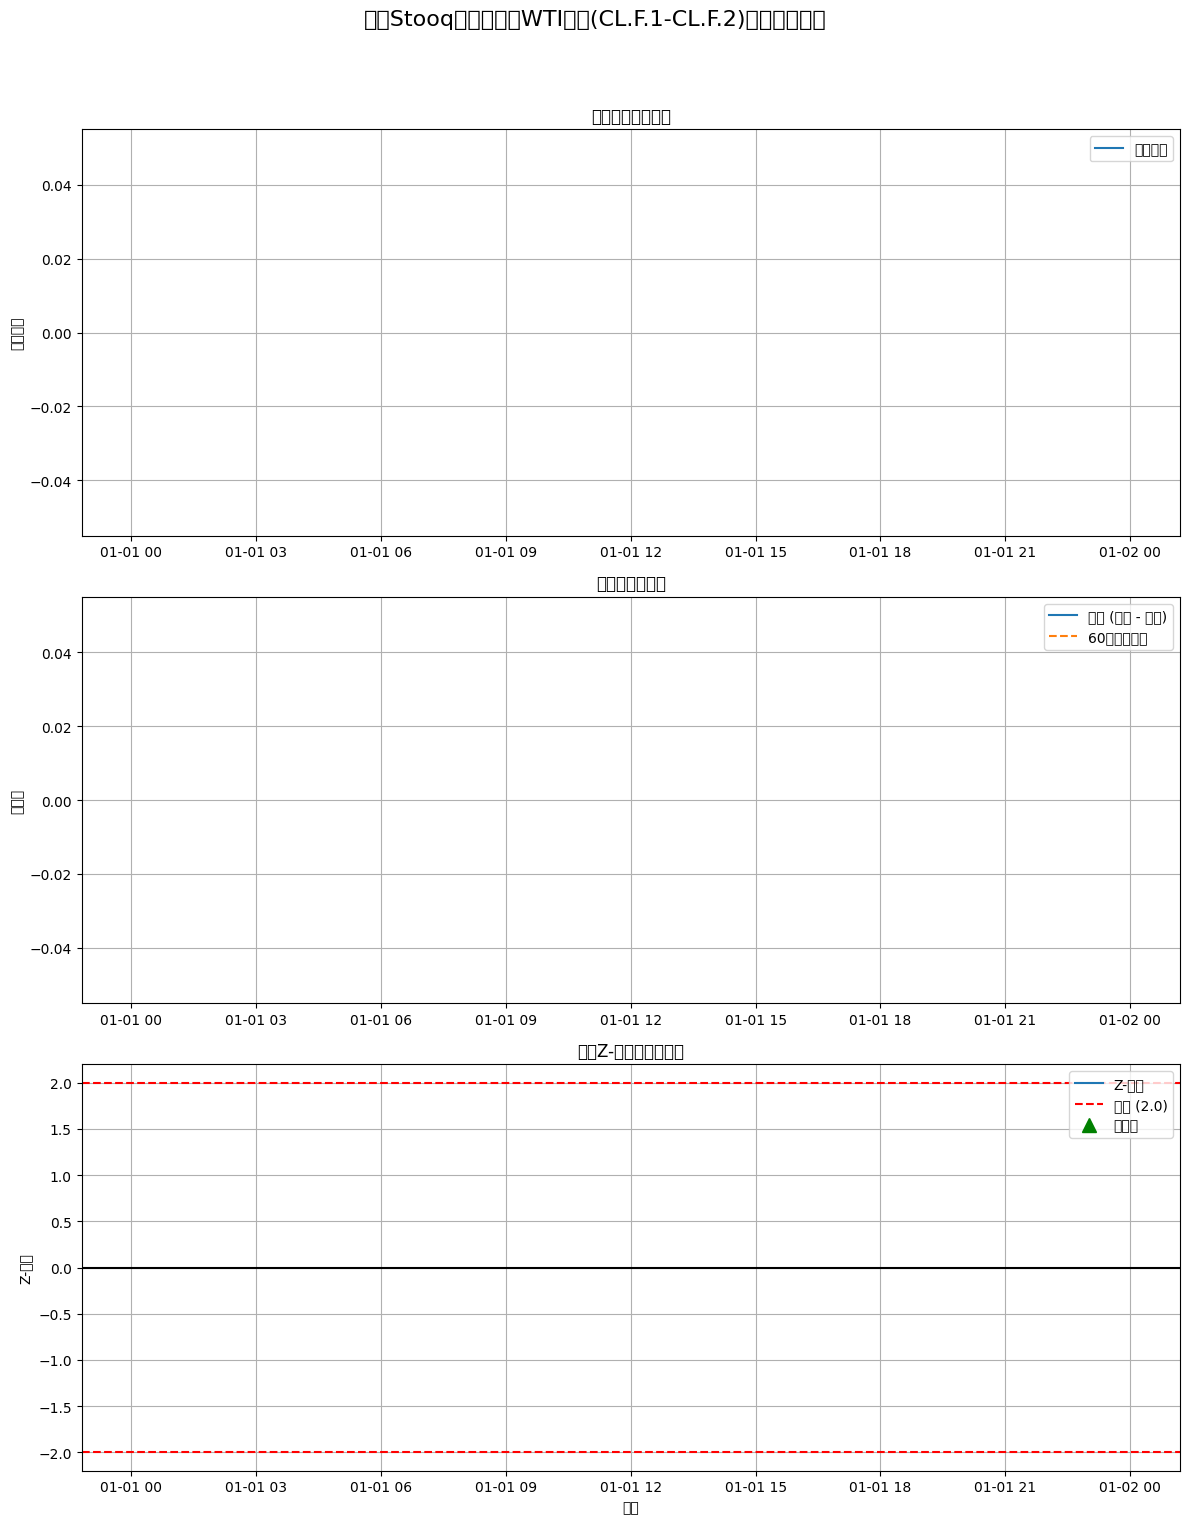

In [45]:
# --- 分析 Stooq 真实数据的结果 ---
if stooq_performance is not None and not stooq_performance.empty:
    print("\n--- 基于 Stooq 真实数据的WTI原油业绩 ---")
    calculate_performance_metrics(stooq_performance)
    plot_performance(stooq_performance, stooq_backtest.strategy, "基于Stooq真实数据的WTI原油(CL.F.1-CL.F.2)价差策略表现")
else:
    print("\n回测未能生成有效结果，请检查数据获取过程中的错误信息。")